In [6]:
# Load in RTMO From rtmlib
!pip install rtmlib -i https://pypi.org/simple

In [7]:
!pip install onnxruntime

In [1]:
import cv2

from rtmlib import Body, draw_skeleton

device = 'cuda'  # cpu, cuda, mps
backend = 'onnxruntime'  # opencv, onnxruntime, openvino

openpose_skeleton = False  # True for openpose-style, False for mmpose-style

wholebody = Body(to_openpose=openpose_skeleton,
                      mode='performance',  # 'performance', 'lightweight', 'balanced'. Default: 'balanced'
                      backend=backend, device=device)


/home/maxwellstone/miniconda3/envs/cis581/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


load /home/maxwellstone/.cache/rtmlib/hub/checkpoints/yolox_x_8xb8-300e_humanart-a39d44ed.onnx with onnxruntime backend
load /home/maxwellstone/.cache/rtmlib/hub/checkpoints/rtmpose-x_simcc-body7_pt-body7_700e-384x288-71d7b7e9_20230629.onnx with onnxruntime backend


In [2]:
# load depth fm
from depthfm import DepthFM

# Load the model
model = DepthFM("checkpoints/depthfm-v1.ckpt")
model.cuda("cuda").eval()

/home/maxwellstone/miniconda3/envs/cis581/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/maxwellstone/miniconda3/envs/cis581/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/maxwellstone/code/CIS5810/depthfm/dfm.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a

DepthFM(
  (vae): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
          

In [1]:
import numpy as np
from PIL import Image
import einops
import torch
from PIL.Image import Resampling


In [40]:
# run rtmo on the cv2 image and return the pose as a list of tuples
def get_pose(image):
    keypoints, scores = wholebody(image)
    return keypoints[0]

def resize_max_res(
    img: Image.Image, max_edge_resolution: int, resample_method=Resampling.BILINEAR
) -> Image.Image:
    """
    Resize image to limit maximum edge length while keeping aspect ratio.

    Args:
        img (`Image.Image`):
            Image to be resized.
        max_edge_resolution (`int`):
            Maximum edge length (pixel).
        resample_method (`PIL.Image.Resampling`):
            Resampling method used to resize images.

    Returns:
        `Image.Image`: Resized image.
    """
    original_width, original_height = img.size
    downscale_factor = min( max_edge_resolution / original_width, max_edge_resolution / original_height)

    new_width  = int(original_width * downscale_factor)
    new_height = int(original_height * downscale_factor)

    new_width  = round(new_width / 64) * 64
    new_height = round(new_height / 64) * 64

    #print(f"Resizing image from {original_width}x{original_height} to {new_width}x{new_height}")

    resized_img = img.resize((new_width, new_height), resample=resample_method)
    return resized_img, (original_width, original_height)

def load_im(cv2_img, processing_res=-1):
    im = Image.fromarray(cv2_img)
    if processing_res < 0:
        processing_res = max(im.size)
    im, orig_res = resize_max_res(im, processing_res)
    x = np.array(im)
    x = einops.rearrange(x, 'h w c -> c h w')
    x = x / 127.5 - 1
    x = torch.tensor(x, dtype=torch.float32)[None]
    return x, orig_res

# run depthfm on the cv2 image and return the depth map
def get_depth(image):
    im, orig_res = load_im(image, 224)
    im = im.cuda(0)
    dtype = torch.bfloat16
    model.model.dtype = dtype
    with torch.autocast(device_type="cuda", dtype=dtype):
        depth = model.predict_depth(im, num_steps=2, ensemble_size=4)
    depth = depth[0].cpu().numpy()
    # upscale depth map to original resolution
    depth = einops.rearrange(depth, 'c h w -> h w c')
    depth = cv2.resize(depth, (orig_res[0], orig_res[1]), interpolation=cv2.INTER_LINEAR)
    return depth

# get pose z dimension from depth map
def get_z(pose, depth):
    res_pose = np.zeros((len(pose), 3))
    for i in range(len(pose)):
        x, y = pose[i]
        z = depth[np.clip(int(y), 0, depth.shape[0]-1)][np.clip(int(x), 0, depth.shape[1]-1)]
        res_pose[i] = (x, y, z)
    return res_pose

# write pose to a txt file where each line is a tuple of idx, x, y, z
def write_pose(pose, filename):
    with open(filename, 'w') as f:
        for i in range(len(pose)):
            x, y, z = pose[i]
            f.write(f"{i},{x},{y},{z}\n")


In [23]:
# test helper functions on test image called test.jpg
image = cv2.imread("test.jpg")
pose = get_pose(image)
print(len(pose))


17


In [24]:
depth = get_depth(image)
pose = get_z(pose, depth)
write_pose(pose, "pose.txt")

Resizing image from 720x1280 to 128x256
(256, 128, 1)
(1280, 720)


In [25]:
# create function to process one image path
def process_image(image_path):
    image = cv2.imread(image_path)
    pose = get_pose(image)
    depth = get_depth(image)
    pose = get_z(pose, depth)
    write_pose(pose, image_path + ".txt")

In [30]:
# process the test image
process_image("test.jpg")

In [41]:
# find all images (recursively) in the dataset/images directory, process them, include a progress bar
import os
from tqdm import tqdm

image_dir = "dataset/images"
image_paths = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith(".jpg") and not os.path.exists(os.path.join(root, file + ".txt")):
            image_paths.append(os.path.join(root, file))

for image_path in tqdm(image_paths):
    process_image(image_path)

 24%|██▍       | 118809/497694 [28:11:35<89:54:32,  1.17it/s] 


KeyboardInterrupt: 

In [42]:
import shutil

# copy all images with a pose file to a new directory, maintaining folder structure
new_dir = "processed_images"

for image_path in image_paths:
    pose_file = image_path + ".txt"
    if os.path.exists(pose_file):
        new_image_path = os.path.join(new_dir, os.path.relpath(image_path, image_dir))
        new_pose_file = new_image_path + ".txt"
        os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
        shutil.copy2(image_path, new_image_path)
        shutil.copy2(pose_file, new_pose_file)


In [45]:
from sklearn.model_selection import train_test_split

# create a test, train, val split with 80% of images in train, 10% in val, 10% in test but keep folders of images together becuase they are a sequence in a video
# Create a dictionary to hold the sequences
# use images from the processed_images directory\
image_dir = "processed_images"
image_paths = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith(".jpg") and os.path.exists(os.path.join(root, file + ".txt")):
            image_paths.append(os.path.join(root, file))
sequences = {}
for path in image_paths:
    sequence = os.path.dirname(path)
    if sequence not in sequences:
        sequences[sequence] = []
    sequences[sequence].append(path)

# Split the sequences into train, val, and test sets
sequences_list = list(sequences.values())
train_sequences, test_sequences = train_test_split(sequences_list, test_size=0.2, random_state=42)
val_sequences, test_sequences = train_test_split(test_sequences, test_size=0.5, random_state=42)

# Flatten the lists of sequences into lists of image paths
train_paths = [path for sequence in train_sequences for path in sequence]
val_paths = [path for sequence in val_sequences for path in sequence]
test_paths = [path for sequence in test_sequences for path in sequence]

print(f"Train: {len(train_paths)} images")
print(f"Validation: {len(val_paths)} images")
print(f"Test: {len(test_paths)} images")

# copy the images to the new directories
for image_path in train_paths:
    pose_file = image_path + ".txt"
    new_image_path = os.path.join("train", os.path.relpath(image_path, image_dir))
    new_pose_file = new_image_path + ".txt"
    os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
    shutil.copy2(image_path, new_image_path)
    shutil.copy2(pose_file, new_pose_file)

for image_path in val_paths:
    pose_file = image_path + ".txt"
    new_image_path = os.path.join("val", os.path.relpath(image_path, image_dir))
    new_pose_file = new_image_path + ".txt"
    os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
    shutil.copy2(image_path, new_image_path)
    shutil.copy2(pose_file, new_pose_file)

for image_path in test_paths:
    pose_file = image_path + ".txt"
    new_image_path = os.path.join("test", os.path.relpath(image_path, image_dir))
    new_pose_file = new_image_path + ".txt"
    os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
    shutil.copy2(image_path, new_image_path)
    shutil.copy2(pose_file, new_pose_file)

Train: 94811 images
Validation: 10943 images
Test: 13055 images


In [35]:
print(image_paths[0] + ".txt")

dataset/images/2023-12-17T213216Z/1702848731706/112.jpg.txt


In [2]:
# create a data loader for the pose dataset
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
class PoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # get all files including subdirectories
        self.files = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.files.append(os.path.join(root, file))

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        keypoints = self.get_keypoints(img_path)
        return image, keypoints
    
    def get_keypoints(self, img_path):
        with open(img_path+".txt", 'r') as f:
            kp_strs = f.readlines()
        keypoints = [[float(p) for p in kp.split(",")[1:]] for kp in kp_strs]
        keypoints = np.array(keypoints)
        keypoints = keypoints[:, [1, 0, 2]]
        return torch.tensor(keypoints, dtype=torch.float32)

In [3]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.Resize((224, 224))
])

train_dataset = PoseDataset("train", transform)
val_dataset = PoseDataset("val", transform)
test_dataset = PoseDataset("test", transform)

# Check the dataset length
print("Train: ", len(train_dataset))
print("Val: ", len(val_dataset))
print("Test: ", len(test_dataset))

Train:  94811
Val:  10943
Test:  13055


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def vis_data_3d(kpts_3d, title=None):
    plt.figure(figsize=(4,4))
    ax = plt.axes(projection='3d')
    single_pose_index = [[5, 7, 9],
                                [6, 8, 10],
                                [5, 6, 12, 11, 5],
                                [11, 13, 15],
                                [12, 14, 16]]
    color_dict = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red', 4:'tab:purple'}
    # Plot each fingers with same color
    for i, finger_index in enumerate(single_pose_index):
        curr_finger_kpts = np.array(kpts_3d[finger_index])
        ax.scatter(curr_finger_kpts[:,0], -curr_finger_kpts[:,1], curr_finger_kpts[:,2], color=color_dict[i])
        ax.plot3D(curr_finger_kpts[:,0], -curr_finger_kpts[:,1], curr_finger_kpts[:,2], color=color_dict[i])
    # Adjust 3D viewing angle as needed
    ax.view_init(elev=-90, azim=180, roll=0)
    if title:
        ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')


tensor([[4.8273e+02, 2.4953e+02, 9.3171e-01],
        [4.7360e+02, 2.5616e+02, 9.3604e-01],
        [4.7112e+02, 2.4123e+02, 9.3405e-01],
        [4.8771e+02, 2.5948e+02, 9.2771e-01],
        [4.7775e+02, 2.0888e+02, 3.1359e-01],
        [5.2752e+02, 2.6114e+02, 4.2175e-01],
        [5.3499e+02, 1.6409e+02, 2.4849e-01],
        [5.1591e+02, 2.5865e+02, 5.1620e-01],
        [5.4162e+02, 1.1100e+02, 5.5564e-01],
        [4.8522e+02, 2.0059e+02, 2.8138e-01],
        [4.9932e+02, 1.6326e+02, 2.9948e-01],
        [6.7932e+02, 2.5036e+02, 2.9723e-01],
        [6.8512e+02, 1.7902e+02, 2.8408e-01],
        [7.9545e+02, 2.8602e+02, 2.5875e-01],
        [7.9959e+02, 1.5248e+02, 3.4096e-01],
        [8.8918e+02, 3.3413e+02, 1.6835e-01],
        [8.9913e+02, 1.0188e+02, 1.6158e-01]])


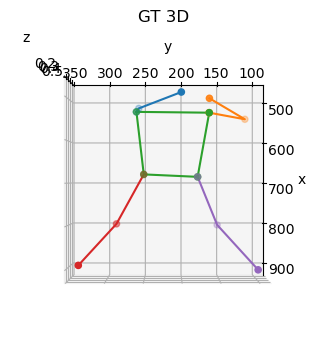

In [5]:
## TODO: Modify as needed to take a look at the dataset
check_dataset = train_dataset
idx = 20000

## Get one dataset sample for visualization
input, pose = check_dataset[idx]
print(pose)

## Visualization of input image and 3d kpts
gt_3d = pose.numpy()
# Assign None to invalid kpts (so it won't be displayed)
vis_data_3d(gt_3d, title="GT 3D")

In [6]:
import os
import time
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from model.model import load_pretrained_weights, PoolAttnHR_Pose_3D
from tqdm import tqdm
from utils.functions import (
    AverageMeter,
    update_config,
)
from utils.loss import mpjpe, p_mpjpe
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maxstone (maxstone-university-of-pennsylvania). Use `wandb login --relogin` to force relogin


True

In [7]:
class Pose3DLoss(nn.Module):
    def __init__(self):
        super(Pose3DLoss, self).__init__()

    def forward(self, pose_3d_pred, pose_3d_gt):
        # Compute MSE loss between pred and gt 3D hand joints for only visible kpts
        assert (
            pose_3d_pred.shape == pose_3d_gt.shape and len(pose_3d_pred.shape) == 3
        )  # (N, K, dim)
        pose_3d_diff = pose_3d_pred - pose_3d_gt
        pose_3d_loss = torch.mean(pose_3d_diff**2, axis=2)
        pose_3d_loss = torch.sum(pose_3d_loss) / pose_3d_loss.shape[0]

        return pose_3d_loss

In [8]:
cfg = {
        "model_cfg": "potter_pose_3d_pose.yaml",
        "potter_cls_weight": "potter_demo.pth",
        "lr": 1e-4,
        "train_bs": 16,
        "val_bs": 16,
        "epochs": 15,
    }

# Simple Test
model_cfg = update_config(cfg["model_cfg"])
model = PoolAttnHR_Pose_3D(**model_cfg.MODEL)

input = torch.rand(1,3,224,224)
output = model(input)
assert output.shape == (1,17,3), "Implementation is incorrect. Please check your PAT block"

input, pose = check_dataset[idx]
input = input.unsqueeze(0)
output = model(input)
print(output.shape)
print(output)




torch.Size([1, 17, 3])
tensor([[[-0.3626, -1.1572,  0.0899],
         [-0.0467, -1.0199, -0.0912],
         [-0.1696,  0.3344, -0.4212],
         [-0.6495,  0.1916,  0.3242],
         [-0.6194, -0.3462, -0.5438],
         [-0.0426,  0.3082, -0.3714],
         [-0.0045,  0.5201,  0.2057],
         [ 0.0095, -0.2347, -1.1689],
         [-0.9211, -1.1737, -0.0545],
         [-0.4638, -0.9780,  0.3533],
         [-0.1374, -0.4363,  0.4200],
         [ 0.7410,  0.4110, -0.4299],
         [-0.1224, -0.2193, -0.2051],
         [-0.1792,  0.6373, -0.4731],
         [-0.4836, -0.1751, -1.0784],
         [-0.8055,  0.3976, -0.5493],
         [ 0.1594,  0.5811, -0.8055]]], grad_fn=<ViewBackward0>)


In [9]:
def train(train_loader, model, criterion, optimizer, device):
    total_loss = AverageMeter()

    # TODO: set model to training mode
    model.train()


    train_loader = tqdm(train_loader, dynamic_ncols=True)
    print_interval = len(train_loader) // 6
    # Iterate over all training samples
    for i, (input, pose_3d_gt) in enumerate(train_loader):
        # TODO:
        # 1. Put all revelant data onto same device
        # 2. Model forward (given cropped hand image, predict a set of 3d kpts)
        input = input.to(device)
        pose_3d_gt = pose_3d_gt.to(device)
        pose_3d_pred = model(input)


        # TODO: Compute loss
        loss = criterion(pose_3d_pred, pose_3d_gt)
        total_loss.update(loss.item())

        # TODO:
        # 1. Clear the old parameter gradients
        # 2. Compute the derivative of loss w.r.t the model parameters
        # 3. Update the model parameters with optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Log loss to wandb
        if (i+1) % print_interval == 0:
            wandb.log({"Loss/train": total_loss.avg})

    # Return average training loss
    return total_loss.avg


def validate(val_loader, model, criterion, device):
    total_loss = AverageMeter()

    # TODO: set model to evaluate mode
    model.eval()


    with torch.no_grad():
        val_loader = tqdm(val_loader, dynamic_ncols=True)
        # Iterate over all validation samples
        for i, (input, pose_3d_gt) in enumerate(val_loader):
            # TODO:
            # 1. Put all revelant data onto same device
            # 2. Model forward (given cropped hand image, predict a set of 3d kpts)
            input = input.to(device)
            pose_3d_gt = pose_3d_gt.to(device)
            pose_3d_pred = model(input)

            # TODO: Compute loss
            loss = criterion(pose_3d_pred, pose_3d_gt)
            total_loss.update(loss.item())

        # Log loss to wandb
        wandb.log({"Loss/val": total_loss.avg})

    # Return average training loss
    return total_loss.avg

In [18]:
# Instantiate the model and define device for training to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cfg = update_config(cfg["model_cfg"])
# Load in pretrained cls weight
model = PoolAttnHR_Pose_3D(**model_cfg.MODEL).to(device)
cls_weight = torch.load("output/2024-12-05-17-58/best_model_weight.pth.tar")
load_pretrained_weights(model.poolattnformer_pose.poolattn_cls, cls_weight)

# TODO: Define loss function (criterion) and optimizer
criterion = Pose3DLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg["train_bs"],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=cfg["val_bs"],
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# TODO: Define current run name
current_run_name = time.strftime("%Y-%m-%d-%H-%M") # Modify as needed, e.g. "test_run_123"
wandb.init(project="CIS 5810 Final Project", name=current_run_name)

Successfully loaded 0 pretrained parameters


/tmp/ipykernel_549774/2204563988.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cls_weight = torch.load("output/2024-12-05-17-58/best_model_weight.pth.tar")


Loss/train,█▇▆▅▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▁▁▁
Loss/train,3628.76793
Loss/val,17608.93678


In [19]:
# Define output directory; modify as needed (where model ckpt will be saved)
output_root = "output"
output_dir = os.path.join(output_root, current_run_name)
print("="*10 + f" Training started. Output will be saved at {output_dir} " + "="*10)
os.makedirs(output_dir, exist_ok=True)

# Default training epoches and best val loss
epochs = cfg["epochs"]
best_val_loss = np.inf

for epoch in range(epochs):
    print("="*10, f"Epoch [{epoch}/{epochs}]", "="*10)
    # train for one epoch
    _ = train(train_loader, model, criterion, optimizer, device)

    # evaluate on validation set
    val_loss = validate(val_loader, model, criterion, device)

    # Save best model weight
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save model weight
        torch.save(model.state_dict(), os.path.join(output_dir, f"best_model_weight.pth.tar"))
        print(f"Saving model weight with best val_loss={val_loss:.5f}")
    print()
print("="*10 + f" Training finished. Got best model with val_loss={best_val_loss:.5f} " + "="*10)
wandb.finish()

========== Training started. Output will be saved at output/2024-12-05-21-26 ==========
========== Epoch [0/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]


Saving model weight with best val_loss=152435.27351

========== Epoch [1/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]


Saving model weight with best val_loss=26178.29385

========== Epoch [2/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]


Saving model weight with best val_loss=20042.83490

========== Epoch [3/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]


Saving model weight with best val_loss=19733.24477

========== Epoch [4/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]


Saving model weight with best val_loss=18008.00837

========== Epoch [5/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.25it/s]


Saving model weight with best val_loss=16583.47250

========== Epoch [6/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.25it/s]


Saving model weight with best val_loss=15861.65567

========== Epoch [7/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]



========== Epoch [8/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]


Saving model weight with best val_loss=14952.23243

========== Epoch [9/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.25it/s]


Saving model weight with best val_loss=14634.35910

========== Epoch [10/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]



========== Epoch [11/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]



========== Epoch [12/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]



========== Epoch [13/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.25it/s]


Saving model weight with best val_loss=14349.64988

========== Epoch [14/15] ==========


100%|██████████| 684/684 [01:34<00:00,  7.26it/s]



========== Training finished. Got best model with val_loss=14349.64988 ==========


Loss/train,█▇▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,1936.25759
Loss/val,15248.07173


In [20]:
def evaluate(test_loader, model, device):
    epoch_loss_3d_pos = AverageMeter()
    epoch_loss_3d_pos_procrustes = AverageMeter()

    with torch.no_grad():
        test_loader = tqdm(test_loader, dynamic_ncols=True)
        for i, (input, pose_3d_gt) in enumerate(test_loader):
            # Pose 3D prediction
            input = input.to(device)
            pose_3d_pred = model(input)

            # Unnormalize predicted and GT pose 3D kpts
            pred_3d_pts = pose_3d_pred.cpu().detach().numpy()
            pred_3d_pts = pred_3d_pts# * test_dataset.joint_std + test_dataset.joint_mean
            gt_3d_kpts = pose_3d_gt.cpu().detach().numpy()
            gt_3d_kpts = gt_3d_kpts# * test_dataset.joint_std + test_dataset.joint_mean

            # Filter out invalid joints
            valid_pred_3d_kpts = torch.from_numpy(pred_3d_pts)
            valid_pred_3d_kpts = valid_pred_3d_kpts.view(1, -1, 3)
            valid_pose_3d_gt = torch.from_numpy(gt_3d_kpts)
            valid_pose_3d_gt = valid_pose_3d_gt.view(1, -1, 3)
            # Compute MPJPE
            epoch_loss_3d_pos.update(mpjpe(valid_pred_3d_kpts, valid_pose_3d_gt).item(), 1)
            epoch_loss_3d_pos_procrustes.update(p_mpjpe(valid_pred_3d_kpts, valid_pose_3d_gt), 1)

    return epoch_loss_3d_pos.avg, epoch_loss_3d_pos_procrustes.avg

In [21]:
# TODO: Initialize model, device and load in pretrained weight. Remember to set model in eval() mode
model = PoolAttnHR_Pose_3D(**model_cfg.MODEL)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
load_pretrained_weights(model, torch.load("output/2024-12-05-17-58/best_model_weight.pth.tar", map_location=device))

# Evalute model performance on test set
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
mpjpe_, pa_mpjpe_ = evaluate(test_loader, model, device)
print(f"Model performance on test set: MPJPE: {mpjpe_:.2f} (mm) PA-MPJPE: {pa_mpjpe_:.2f} (mm)")

/tmp/ipykernel_549774/3811815418.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_pretrained_weights(model, torch.load("output/2024-12-05-17-58/best_model_weight.pth

Successfully loaded 416 pretrained parameters


100%|██████████| 13055/13055 [04:29<00:00, 48.36it/s]

Model performance on test set: MPJPE: 57.56 (mm) PA-MPJPE: 26.16 (mm)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9685228..2.6367896].


[[3.6720648e+02 2.8273663e+02 4.7828463e-01]
 [3.5380856e+02 2.8465060e+02 5.1947397e-01]
 [3.5572256e+02 2.7029572e+02 1.8634523e-01]
 [3.5859354e+02 2.4541391e+02 2.4603117e-01]
 [3.5955054e+02 2.3393001e+02 2.6496968e-01]
 [4.1122812e+02 3.0570444e+02 1.3066943e-01]
 [4.2175504e+02 1.8895135e+02 1.2261798e-01]
 [4.9544345e+02 2.8847858e+02 1.1808212e-01]
 [5.0692737e+02 1.5067166e+02 5.0165659e-01]
 [4.5907776e+02 1.9660730e+02 1.2378581e-01]
 [4.4376587e+02 1.5354263e+02 2.9469916e-01]
 [5.7965881e+02 2.9326355e+02 1.0711394e-01]
 [5.7870178e+02 2.1287617e+02 1.0186521e-01]
 [7.0598181e+02 3.2675827e+02 7.4862465e-02]
 [7.0023987e+02 1.7268250e+02 8.0912434e-02]
 [8.1125098e+02 3.6408099e+02 3.6170222e-02]
 [7.9115411e+02 1.5354263e+02 4.8123714e-02]]


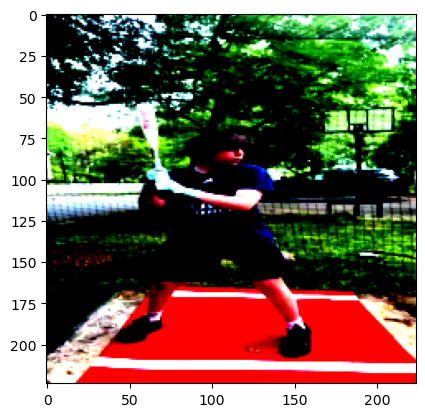

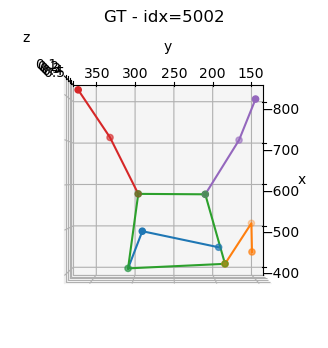

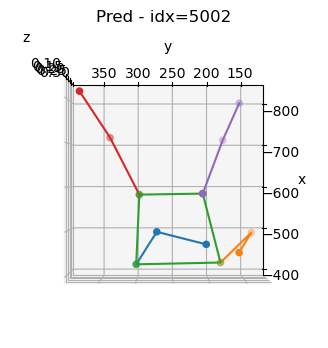

In [37]:
# TODO: Select random idx
vis_idx = 5002
input, pose_3d_gt= test_dataset[vis_idx]

plt.imshow(input.permute(1,2,0))

# Visualize ground truth 3D hand kpts
gt_3d = pose_3d_gt.numpy()
print(gt_3d)
vis_data_3d(gt_3d, title=f"GT - idx={vis_idx}")

# TODO: Visualize predicted 3D hand kpts
pred_kpts_3d = model(torch.unsqueeze(input.to(device), 0)).detach().cpu().numpy()[0]
vis_data_3d(pred_kpts_3d, title=f"Pred - idx={vis_idx}")